In [ ]:
pip install matplotlib
pip install PyQt5
pip install numpy
pip install scipy

In [260]:
import numpy as np
import glob, os, copy
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
plt.ion
np.set_printoptions(precision=2, suppress=True)

<ipython-input-260-67757f6be005>:5: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [263]:
# def check_validity(current_data_value, previous_average):
def check_diff_invalidity(current_data_value, previous_average):    
    epsilon = 0.75
    return not(np.linalg.norm(current_data_value - previous_average) <= epsilon)

def check_stat_invalidity(current_data_value, previous_average):
    epsilon = 1.0
    statistical_mean = np.array([3.45, -2.4, 0.75])
    return np.linalg.norm(current_data_value - statistical_mean) <= epsilon

def check_stat_and_diff_invalidity(current_data_value, previous_average, t, latest_valid_index):

    if latest_valid_index==-1:
        previous_average = current_data_value
            
    invalid = check_diff_invalidity(current_data_value, previous_average) or check_stat_invalidity(current_data_value, previous_average)

    return invalid
    
    # return check_diff_invalidity(current_data_value, previous_average) and check_stat_invalidity(current_data_value, previous_average)
    # return check_diff_invalidity(current_data_value, previous_average) or check_stat_invalidity(current_data_value, previous_average)

def filter_outliers(data):

    filter_size = 3
    # epsilon = 0.5 * np.ones(3)
    epsilon = 0.5
    alt_data = copy.deepcopy(data)
    averages = np.zeros_like(data)
    validity = np.ones(data.shape[0])
    latest_valid_index = -1

    # Initialize average.
    averages[0] = data[0]    

    print("Hello, about to start filtering.")    

    for k in range(1, data.shape[0]):
        
        # Check validity
        # If we think it's an outlying datapoint based on averages, rewrite the data to last valid data point, 
        # and set validity to 0. 
        # if not(check_diff_validity(alt_data[k], averages[k-1])):
        # if not(check_stat_validity(alt_data[k], averages[k-1])):   
        if check_stat_and_diff_invalidity(alt_data[k], averages[k-1], k, latest_valid_index):
            alt_data[k] = copy.deepcopy(alt_data[k-1])
            validity[k] = 0.
            # The average is now defined as the mean over the previous filter_size - 1 elements, and the current element.. 
            # averages[k] = alt_data[max(0, k+1-filter_size):k+1].mean(axis=0)
            averages[k] = alt_data[max(latest_valid_index, k+1-filter_size):k+1].mean(axis=0)
        else:            
            # Special case ofr us encountering the first valid data point afer a stream of invalid data points. 
            if latest_valid_index == -1:
                # Set average to current value.. 
                averages[k] = alt_data[k]
            else:
                # The average is now defined as the mean over the previous filter_size - 1 elements, and the current element.. 
                # averages[k] = alt_data[max(0, k+1-filter_size):k+1].mean(axis=0)
                averages[k] = alt_data[max(latest_valid_index, k+1-filter_size):k+1].mean(axis=0)

            # Set the last valid index to current timepoint. 
            latest_valid_index = k

        # print("#######################")
        # print("Filtering timestep: ", k)
        # print(data[k], averages[k-1], np.linalg.norm(data[k] - averages[k-1]))

        # The average is now defined as the mean over the previous filter_size - 1 elements, and the current element.. 
        # averages[k] = alt_data[max(0, k+1-filter_size):k+1].mean(axis=0)
    
    return averages, validity

In [264]:
def interpolate_position(valid=None, position_sequence=None):
	
	from scipy import interpolate
	
	# Interp1d from Scipy expects the last dimension to be the dimension we are ninterpolating over. 	
	valid_positions = np.swapaxes(position_sequence[valid==1], 1, 0)
	valid_times = np.where(valid==1)[0]
	query_times = np.arange(0, len(position_sequence))

	# Create interpolating function. 
	interpolating_function = interpolate.interp1d(valid_times, valid_positions)

	# Query interpolating function. 
	interpolated_positions = interpolating_function(query_times)

	# Swap axes back and return. 
	return np.swapaxes(interpolated_positions, 1, 0)

def interpolate_orientation(valid=None, orientation_sequence=None):

	from scipy.spatial.transform import Rotation as R
	from scipy.spatial.transform import Slerp

	valid_orientations = orientation_sequence[valid==1]
	rotation_sequence = R.concatenate(R.from_quat(valid_orientations))
	valid_times = np.where(valid==1)[0]
	query_times = np.arange(0, len(orientation_sequence))

	# Create slerp object. 
	slerp_object = Slerp(valid_times, rotation_sequence)

	# Query the slerp object. 
	interpolated_rotations = slerp_object(query_times)

	# Convert to quaternions.
	interpolated_quaternion_sequence = interpolated_rotations.as_quat()
	
	return interpolated_quaternion_sequence

def interpolate_valid_data(valid_data, validity):

    # Really this should follow the exact same pipeline as remaining dataloader stuff.. 
	# Last elements will always be valid. 
	# First may not be - backfill this. 

	# Phase 2.a : The first few elements may not be valid (here, the last elements always will be). 
	# If so, backfill first few elements with the first valid element. 
	first_valid_index = np.where(validity)[0][0]
	if first_valid_index>0:
		valid_data[:first_valid_index] = valid_data[first_valid_index]
		validity[:first_valid_index] = 1

	# Phase 2.b : Now that we have valid starts and ends, interpolate the data. 
	interpolated_data = interpolate_position(valid=validity, position_sequence=valid_data)
	
	return interpolated_data

In [261]:
# def old_process_data(data):

#     # Select Posiiton Data.
#     processed_data = data[1:, 10:13]
#     filtered_data, validity = filter_outliers(processed_data)
#     return filtered_data

def process_data(data):

    # Select Posiiton Data.
    processed_data = data[1:, 10:13]
    filtered_data, validity = filter_outliers(processed_data)
    # filtered_data = processed_data

    # Interpolate data - second phase 
    interpolated_data = interpolate_valid_data(filtered_data, validity)

    # Smoothen data
    kernel_bandwidth = 3
    smoothed_data = gaussian_filter1d(interpolated_data,kernel_bandwidth,axis=0,mode='nearest')

    # return filtered_data
    # return interpolated_data
    return smoothed_data

def plot_traj(original_data, processed_data):
    # plt.close()
    plt.figure()
    plt.plot(original_data)
    plt.plot(processed_data, 'o', markersize=2)
    plt.show()

################
Processing file:  0  , named:  close_door_0.csv
Hello, about to start filtering.


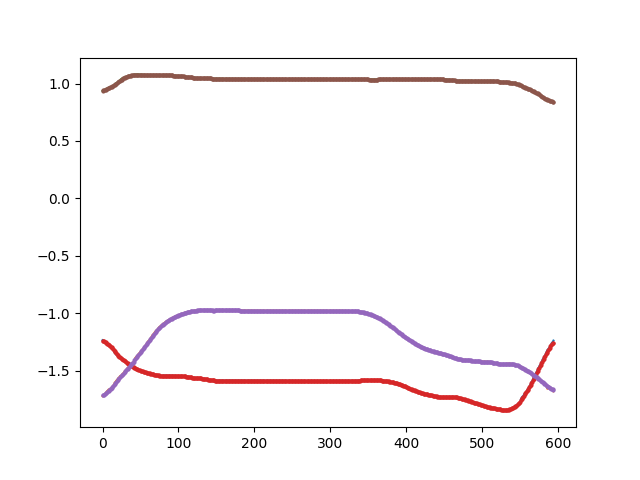

################
Processing file:  1  , named:  close_door_1.csv
Hello, about to start filtering.


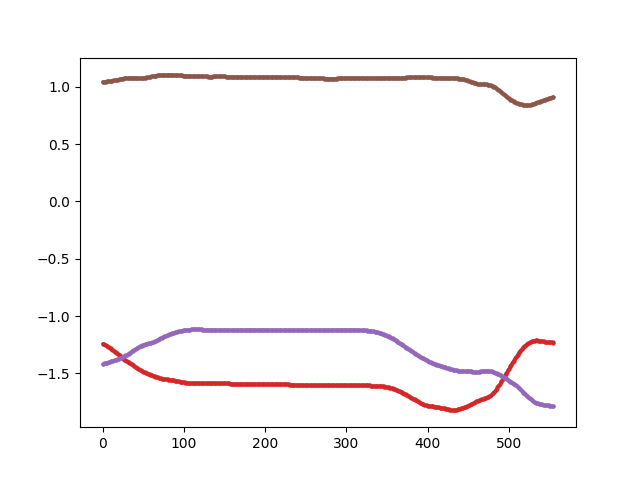

################
Processing file:  2  , named:  eggs_0.csv
Hello, about to start filtering.


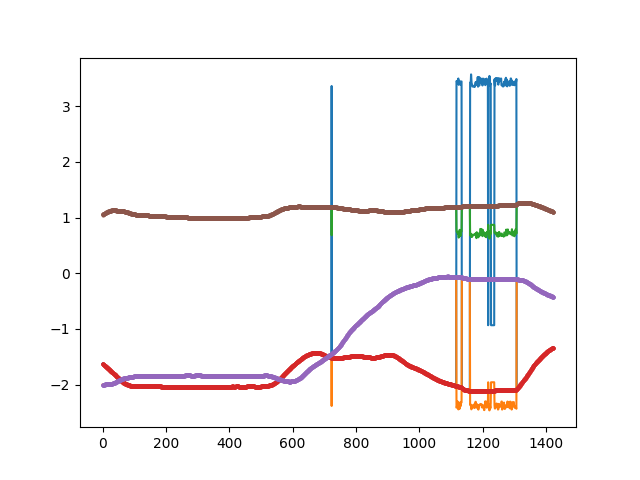

################
Processing file:  3  , named:  eggs_1.csv
Hello, about to start filtering.


<ipython-input-263-6e6b095b6cdb>:50: RuntimeWarning: Mean of empty slice.
  averages[k] = alt_data[max(latest_valid_index, k+1-filter_size):k+1].mean(axis=0)
c:\Users\tshankar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


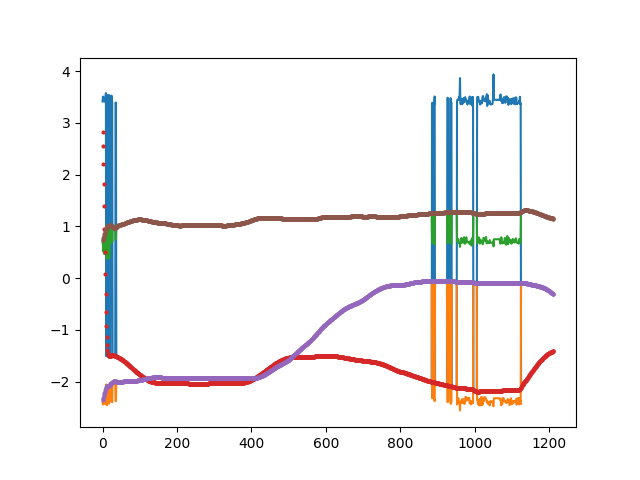

################
Processing file:  4  , named:  open_door_0.csv
Hello, about to start filtering.


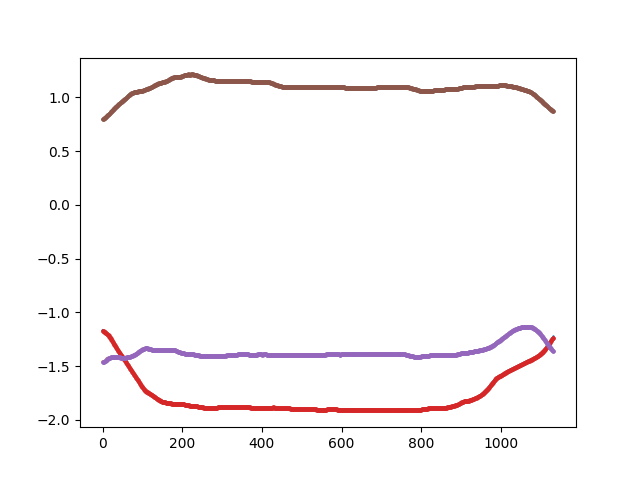

################
Processing file:  5  , named:  open_door_1.csv
Hello, about to start filtering.


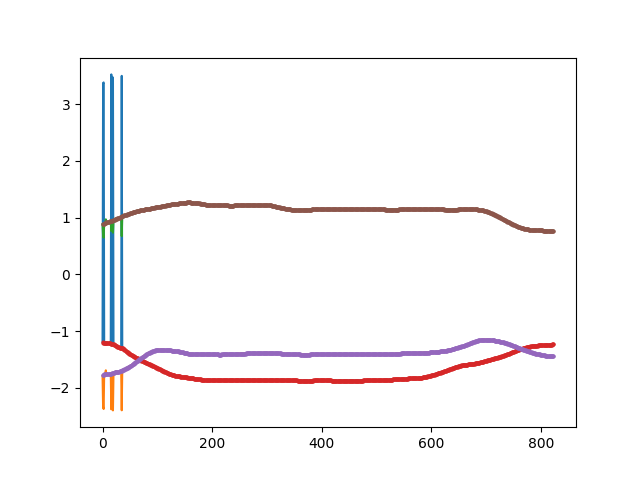

################
Processing file:  6  , named:  open_door_2.csv
Hello, about to start filtering.


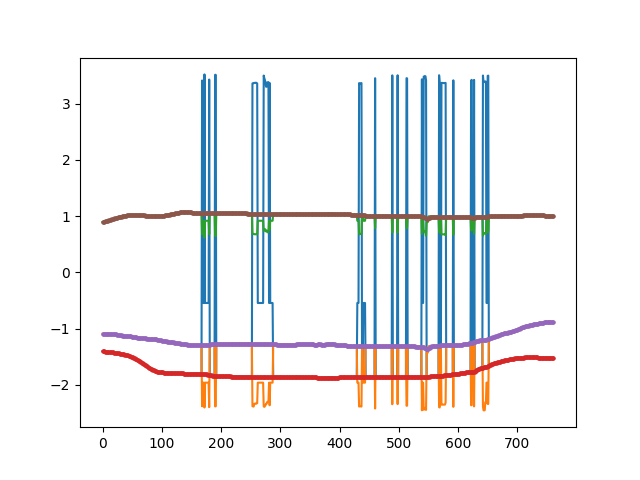

################
Processing file:  7  , named:  stock_cupboard_0.csv
Hello, about to start filtering.


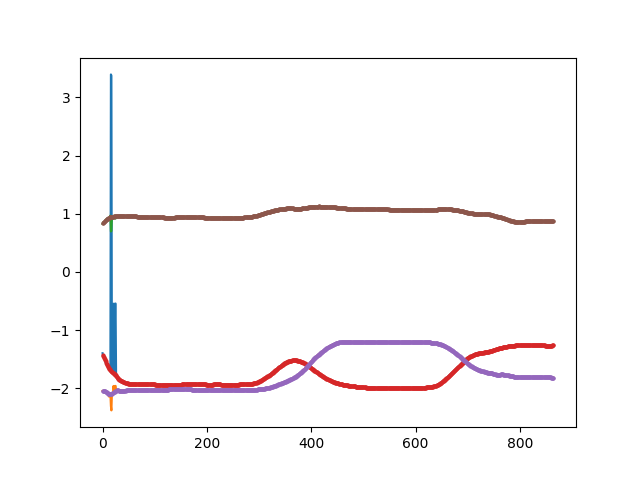

################
Processing file:  8  , named:  stock_cupboard_1.csv
Hello, about to start filtering.


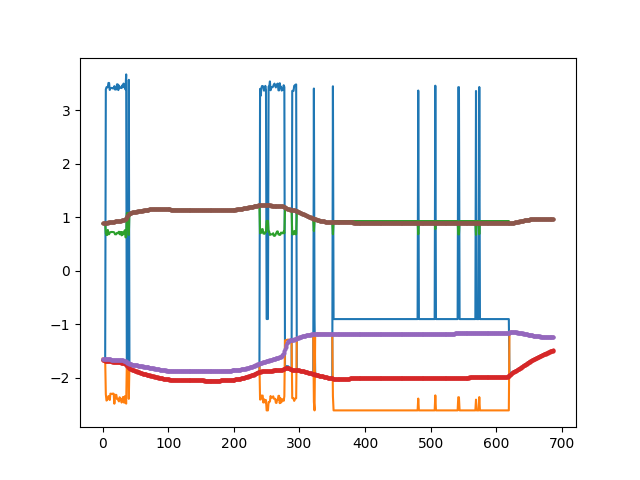

################
Processing file:  9  , named:  stock_cupboard_2.csv
Hello, about to start filtering.


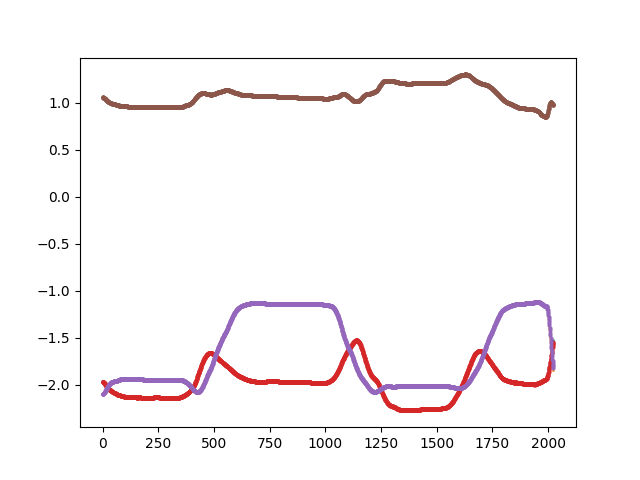

################
Processing file:  10  , named:  stock_cupboard_3.csv
Hello, about to start filtering.


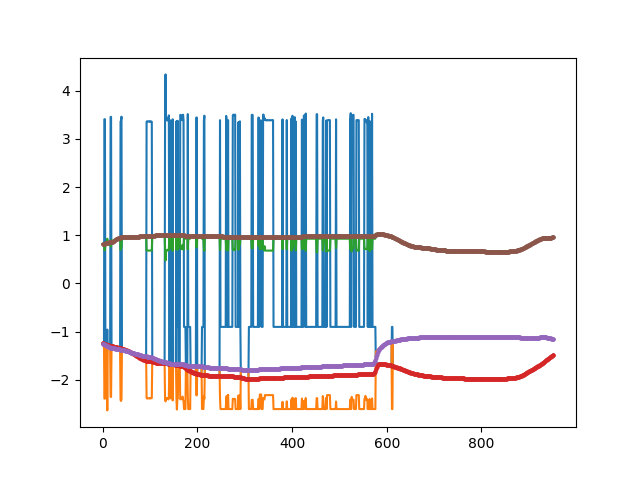

################
Processing file:  11  , named:  stock_fridge_0.csv
Hello, about to start filtering.


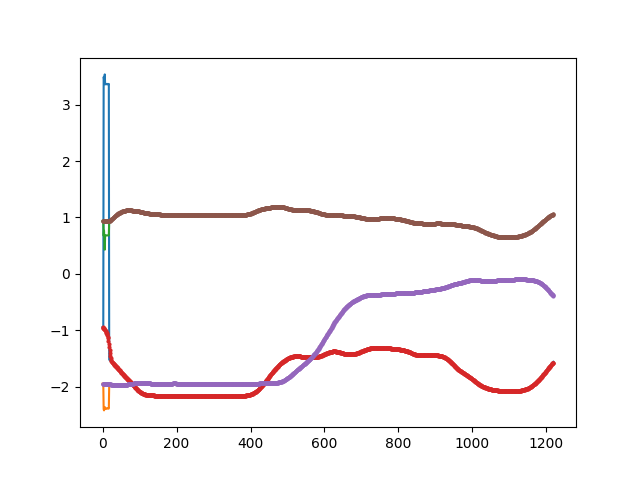

################
Processing file:  12  , named:  stock_fridge_1.csv
Hello, about to start filtering.


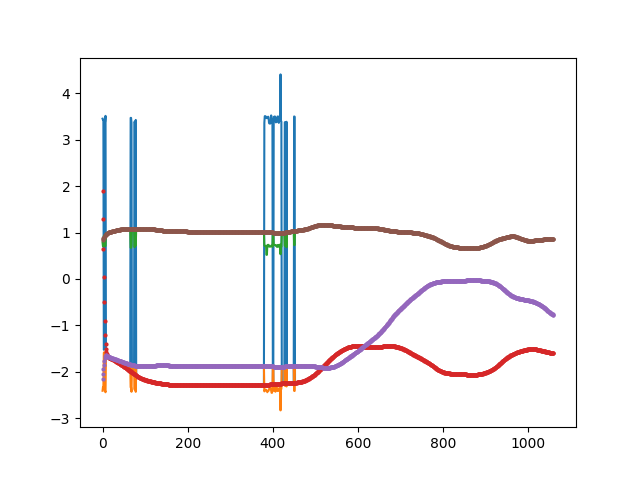

################
Processing file:  13  , named:  stock_fridge_2.csv
Hello, about to start filtering.


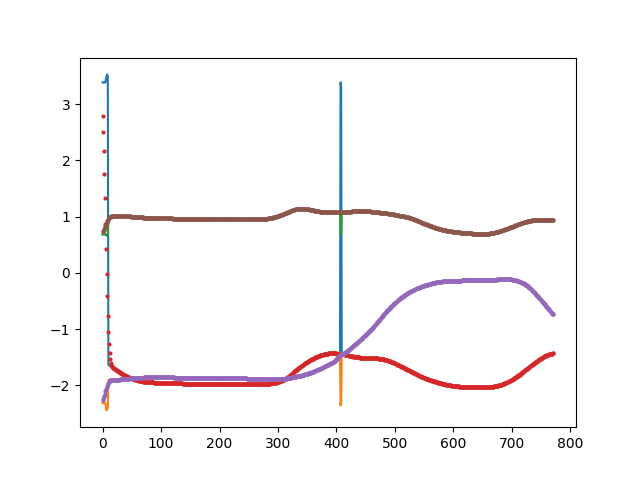

################
Processing file:  14  , named:  stock_fridge_3.csv
Hello, about to start filtering.


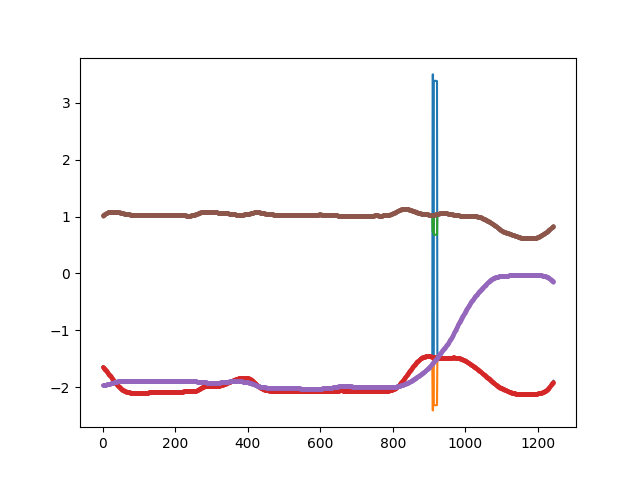

In [268]:
filelist = sorted(glob.glob("*.csv"))

for k,v in enumerate(filelist):

    # if not(v.startswith("stock_cupboard")):
    if True:
    
        print("################")
        print("Processing file: ", k, " , named: ", v)

        # Extract from file
        data = np.genfromtxt(v, delimiter=',')
        # process
        pdata = process_data(data)
        # plot
        plot_traj(data[1:, 10:13], pdata)

In [266]:
data = np.genfromtxt('stock_cupboard_1.csv', delimiter=',')
processed_data = data[1:, 10:13]
filtered_data, validity = filter_outliers(processed_data)

Hello, about to start filtering.


In [267]:
validity

array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

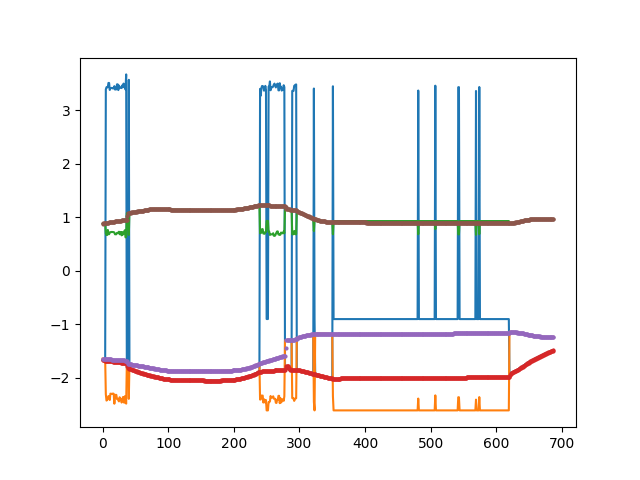

In [237]:
# interpolated_data = interpolate_valid_data(filtered_data, validity)
position_sequence = filtered_data
valid = validity

from scipy import interpolate

# Interp1d from Scipy expects the last dimension to be the dimension we are ninterpolating over. 
valid_positions = np.swapaxes(position_sequence[valid==1], 1, 0)
valid_times = np.where(valid==1)[0]
query_times = np.arange(0, len(position_sequence))

interpolating_function = interpolate.interp1d(valid_times, valid_positions)
interpolated_positions = interpolating_function(query_times)
interpolated_data = np.swapaxes(interpolated_positions, 1, 0)
interpolated_data.shape

plot_traj(data[1:, 10:13], interpolated_data)

################
Processing file:  0  , named:  close_door_0.csv
Hello, about to start filtering.


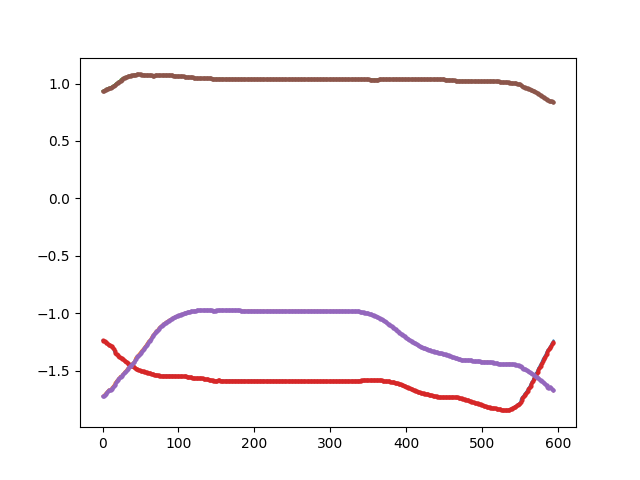

################
Processing file:  1  , named:  close_door_1.csv
Hello, about to start filtering.


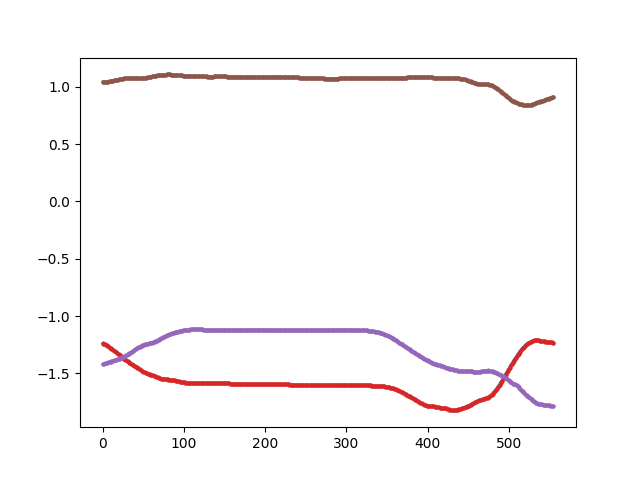

################
Processing file:  2  , named:  eggs_0.csv
Hello, about to start filtering.


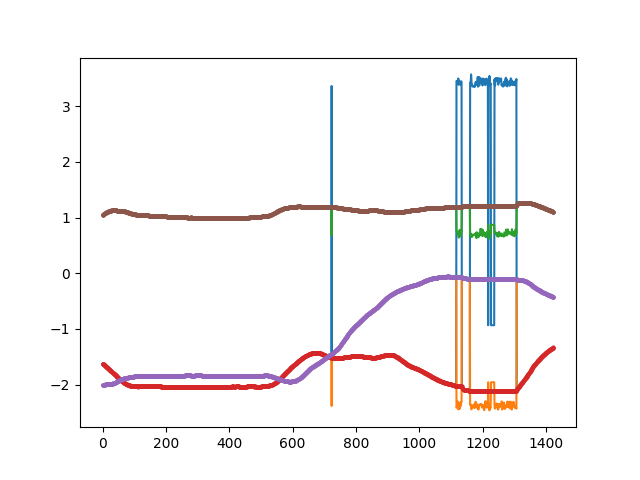

################
Processing file:  3  , named:  eggs_1.csv
Hello, about to start filtering.


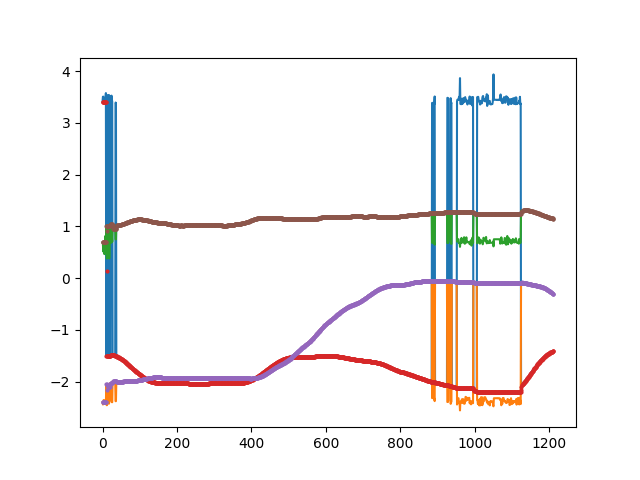

################
Processing file:  4  , named:  open_door_0.csv
Hello, about to start filtering.


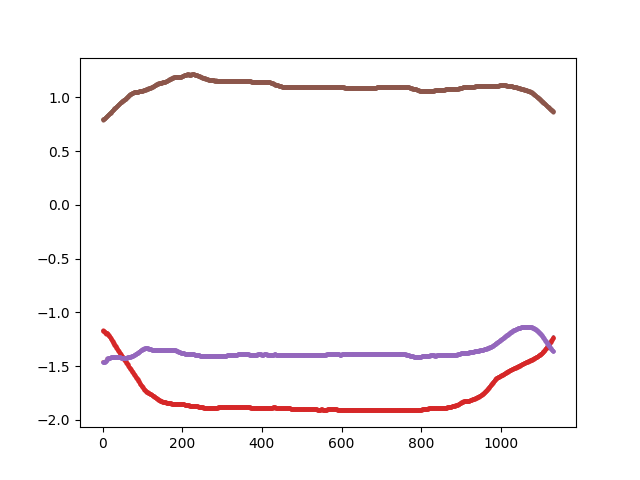

################
Processing file:  5  , named:  open_door_1.csv
Hello, about to start filtering.


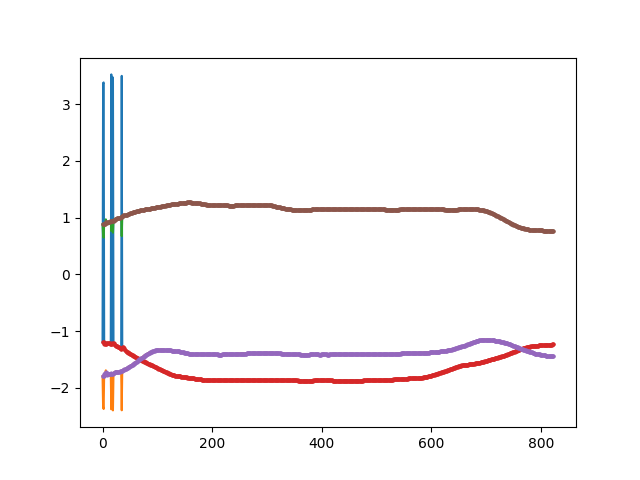

################
Processing file:  6  , named:  open_door_2.csv
Hello, about to start filtering.


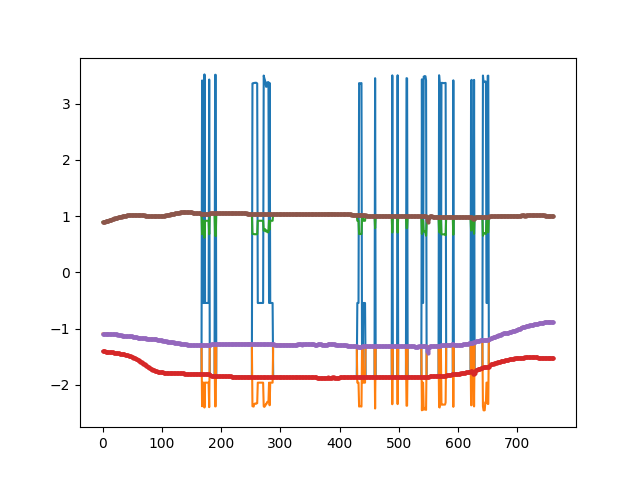

################
Processing file:  7  , named:  stock_cupboard_0.csv
Hello, about to start filtering.


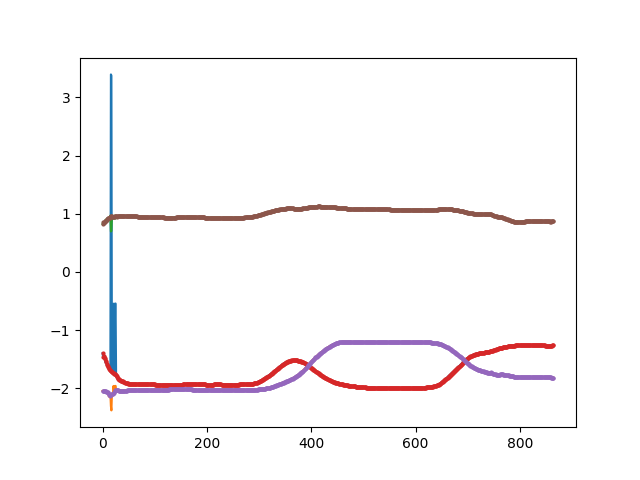

################
Processing file:  8  , named:  stock_cupboard_1.csv
Hello, about to start filtering.


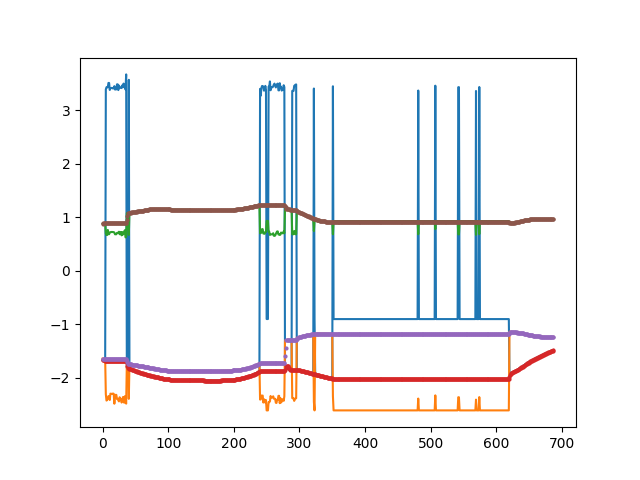

################
Processing file:  9  , named:  stock_cupboard_2.csv
Hello, about to start filtering.


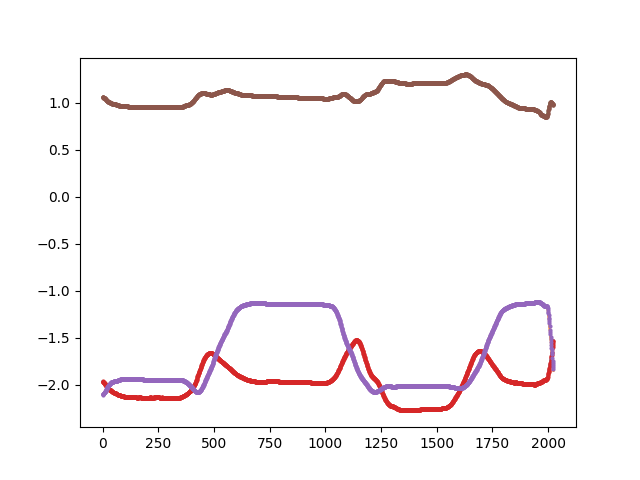

################
Processing file:  10  , named:  stock_cupboard_3.csv
Hello, about to start filtering.


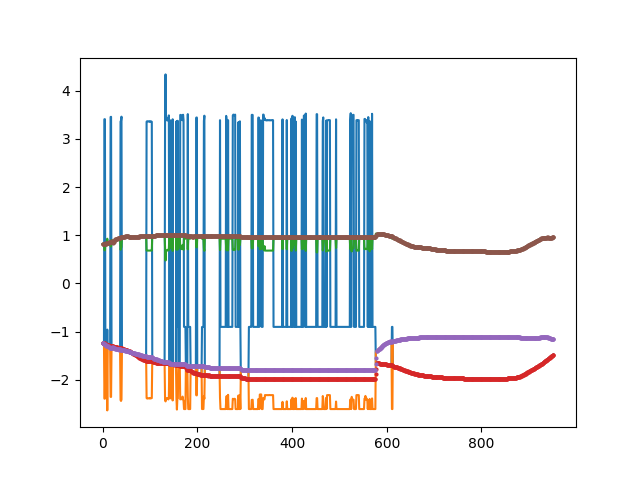

################
Processing file:  11  , named:  stock_fridge_0.csv
Hello, about to start filtering.


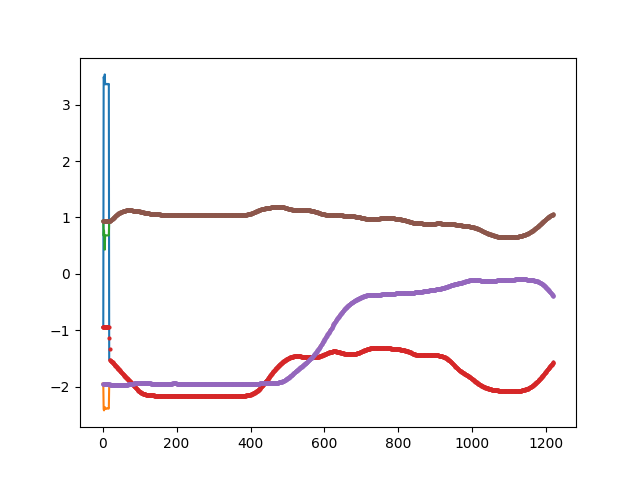

################
Processing file:  12  , named:  stock_fridge_1.csv
Hello, about to start filtering.


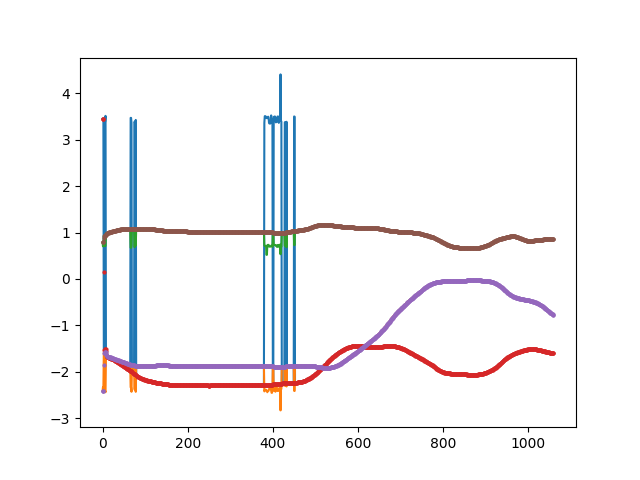

################
Processing file:  13  , named:  stock_fridge_2.csv
Hello, about to start filtering.


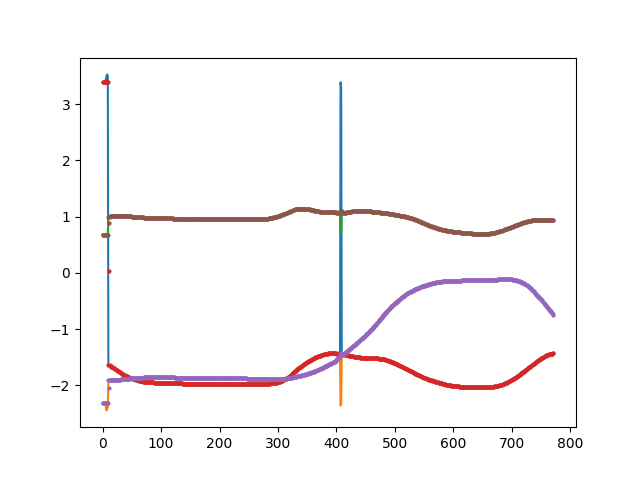

################
Processing file:  14  , named:  stock_fridge_3.csv
Hello, about to start filtering.


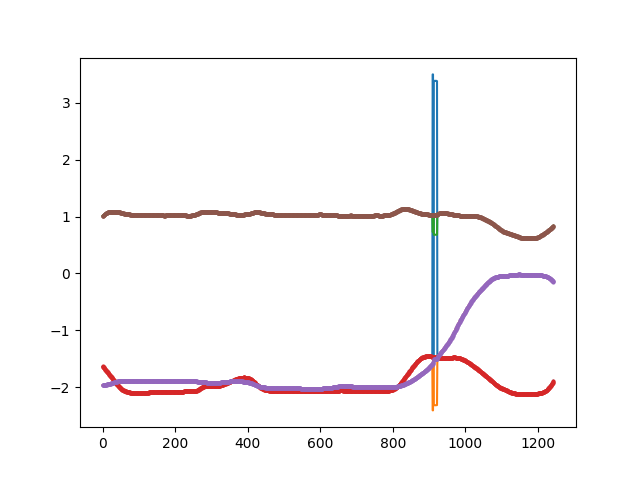

In [208]:
filelist = sorted(glob.glob("*.csv"))

for k,v in enumerate(filelist):

    # if not(v.startswith("stock_cupboard")):
    if True:
    
        print("################")
        print("Processing file: ", k, " , named: ", v)

        # Extract from file
        data = np.genfromtxt(v, delimiter=',')
        # process
        pdata = process_data(data)
        # plot
        plot_traj(data[1:, 10:13], pdata)